In [1]:
from util import *
from feature_eng import *

In [2]:
from ipywidgets import interact, widgets
from IPython.display import display

In [3]:
years = [2016, 2017, 2018, 2019]
origin_df = []

for year in years:
    file_name = f'TEDS-D-{year}-DS0001-bndl-data-tsv'
    if year == 2019:
        file_name += '_V1.zip'
    else:
        file_name += '.zip'
    origin_df.append(read_csv(file_name))

In [7]:
df = pd.concat(origin_df)

In [8]:
df.head()

,DISYR,CASEID,STFIPS,AGE,SERVICES,SUB1,SUB2,SUB3,DETCRIM,NOPRIOR,...,OTHERFLG,NUMSUBS,IDU,DIVISION,REGION,ALCDRUG,YEAR,CBSA,GENDER,CBSA2010
0,2016,20161314323,2,6,7,2,1,1,-9,1,...,0,1.0,0,9,4,1,2016.0,-9.0,2,NaN
1,2016,20161235303,2,5,7,2,1,1,-9,1,...,0,1.0,0,9,4,1,2016.0,-9.0,2,NaN
2,2016,20161216159,2,4,7,4,10,1,-9,0,...,0,2.0,1,9,4,2,2016.0,-9.0,2,NaN
3,2016,20161185262,2,4,7,10,4,2,-9,0,...,0,3.0,1,9,4,3,2016.0,-9.0,2,NaN
4,2016,20161248228,2,5,7,2,1,1,-9,1,...,0,1.0,0,9,4,1,2016.0,-9.0,1,NaN


In [9]:
df['state'] = df['STFIPS'].apply(lambda x: US_STATE_TO_ABBREV[STATE_DICT[x]])
df['REASON'] = df['REASON'].apply(lambda x: REASON_DICT[x])

In [59]:
years_widget = widgets.IntRangeSlider(
    value=[min(years), max(years)],
    min=min(years),
    max=max(years),
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

state_list = sorted(list(df['state'].unique()))
state = widgets.SelectMultiple(
    options=state_list,
    value=state_list,
    description='States:',
)

df_columns = sorted(list(df.columns.unique()))
df_columns.remove('state')
df_columns.remove('DISYR')
column = widgets.Dropdown(
    options=df_columns,
    value='REASON',
    description='Column:',
)

reason_classes = sorted(list(df['REASON'].unique()))
column_classes = widgets.Dropdown(
    options=reason_classes,
    value=reason_classes[0],
    description='Classes:'
)

button = widgets.Button(description="Update Map!")

def view_map(button):
    year_min, year_max = years_widget.value
    if year_min == year_max:
        tmp_df = df[df['DISYR'] == year_min]
    else:
        tmp_df = df[df['DISYR'].isin(list(range(year_min, year_max + 1)))]
    if len(state.value) == len(tmp_df['state'].unique()):
        tmp_df = df[df['state'].isin(state.value)]
    else:
        tmp_df = df
    tmp_df = tmp_df[tmp_df[column.value] == column_classes.value]
    tmp_df = tmp_df[['state', column.value]].value_counts().reset_index()
    with g.batch_update():
        g.data[0].locations = tmp_df['state']
        g.data[0].z = tmp_df[0]
        title = f"Class `{column_classes.value}` count in column {column.value}"
        if len(state.value) == len(tmp_df['state'].unique()):
            title += " in all states"
        else:
            title += " in " + ", ".join(x for x in state.value)
        if year_min == 2016 and year_max == 2019:
            title += " in all years"
        elif year_min == year_max:
            title += f" in {year_min}"
        else:
            title += f" from {year_min} to {year_max}"
        g.layout.title = title
        g.layout.xaxis.title = 'Delay in Minutes'

# Define function to bind value of the input to the output variable 
def change_classes(change):
    if change['type'] == 'change' and change['name'] == 'value':
        col = change.new
        column_classes.options = sorted(list(df[col].unique()))

def change_state(change):
    if change['type'] == 'change' and change['name'] == 'value':
        year_range = list(range(change.new[0], change.new[1] + 1))
        if year_range:
            filtered_df = df[df['DISYR'].isin(year_range)]
        else:
            # min equals max
            filtered_df = df[df['DISYR'] == change.new[0]]
        new_state = sorted(list(filtered_df['state'].unique()))
        state.options = new_state
        state.value = new_state
        
column.observe(change_classes)
years_widget.observe(change_state)

button.on_click(view_map)


display(years_widget, state, column, column_classes, button)
empty_map = go.Choropleth(locationmode = 'USA-states',
            colorscale = 'Blues',
            colorbar_title = 'title')
g = go.FigureWidget(data=[empty_map])
g.update_layout(title_text = 'Default title', geo_scope='usa')

IntRangeSlider(value=(2016, 2019), continuous_update=False, description='Year:', max=2019, min=2016)

SelectMultiple(description='States:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…

Dropdown(description='Column:', index=59, options=('AGE', 'ALCDRUG', 'ALCFLG', 'AMPHFLG', 'ARRESTS', 'ARRESTS_…

Dropdown(description='Classes:', options=('1 - Treatment Completed', '2 - Dropped out of treatment', '3 - Term…

Button(description='Update Map!', style=ButtonStyle())

FigureWidget({
    'data': [{'colorbar': {'title': {'text': 'title'}},
              'colorscale': [[0.0, 'rgb…

<AxesSubplot:>

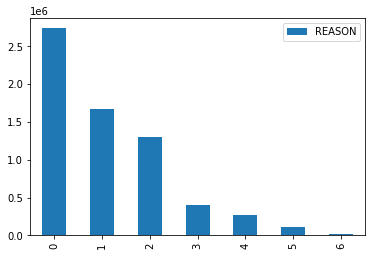

In [14]:
df['REASON'].value_counts().reset_index().plot.bar()

In [81]:
import plotly.express as px
# count_df = df[['state', 'REASON']].value_counts(normalize=True).reset_index()
# count_df.columns = ['state', 'REASON', 'count']
# count_df.groupby(['state'])['count'].sum()
# count_df = df.groupby(['state']).agg({'REASON': [('count', lambda x: list(x.value_counts()))]}, )#.reset_index(level=[0,1])
#['REASON'].value_counts(normalize=True)
# count_df.columns = ['state', 'REASON', 'count']
# count_df
count_df = pd.DataFrame(df.groupby(['state'])['REASON'].value_counts(normalize=True))
count_df.columns = ['count']
count_df = count_df.reset_index()

In [82]:
fig = px.bar(count_df, x="state", y="count", color="REASON", title="Long-Form Input")
fig.show()